In [68]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
import os
from dotenv import load_dotenv

load_dotenv()

# Initialize LangChain LLM
llm = ChatGroq(
    groq_api_key=os.getenv("GROQ_API_KEY"),
    model_name="llama3-70b-8192",
    temperature=0.4,
    max_retries=3,
    timeout=30
)

def get_llm_response(prompt):
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        return response.content.strip()
    except Exception as e:
        return f"Error querying LLM: {e}"


In [90]:
import joblib
import numpy as np
import docx
import PyPDF2
import os

# === Load your trained artifacts ===
clf = joblib.load("model/knn_resume_classifier.joblib")
vectorizer = joblib.load("model/resume_vectorizer.joblib")
le = joblib.load("model/label_encoder.joblib")

# === Step 1: Extract text from file ===
def extract_text_from_file(file_path):
    if file_path.lower().endswith(".txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    elif file_path.lower().endswith(".docx"):
        doc = docx.Document(file_path)
        return "\n".join([para.text for para in doc.paragraphs])
    elif file_path.lower().endswith(".pdf"):
        text = ""
        with open(file_path, "rb") as f:
            pdf_reader = PyPDF2.PdfReader(f)
            for page in pdf_reader.pages:
                if page.extract_text():
                    text += page.extract_text() + "\n"
        return text
    else:
        raise ValueError("Unsupported file type. Use PDF, DOCX, or TXT.")

# === Step 2: Resume content check ===
def is_resume(text):
    resume_keywords = [
        "experience", "work history", "employment", "career",
        "education", "academic background", "degree", "university", "college",
        "skills", "technical skills", "soft skills", "competencies",
        "projects", "portfolio", "publications", "research",
        "certifications", "licenses", "training", "courses",
        "summary", "objective", "profile", "about me",
        "achievements", "awards", "honors",
        "languages", "tools", "frameworks",
        "contact", "email", "phone", "linkedin", "github"
    ]
    text_lower = text.lower()
    matches = sum(1 for kw in resume_keywords if kw in text_lower)
    return matches >= 3  # Require at least 3 keywords

# === Step 3: Predict domain ===
def predict_domain(resume_text):
    X_new = vectorizer.transform([resume_text])
    pred_idx = clf.predict(X_new)[0]
    return le.inverse_transform([pred_idx])[0]

# === Step 4: Build LLM prompt ===
def build_prompt_from_file(file_path):
    resume_text = extract_text_from_file(file_path)
    
    # Validate resume
    if not is_resume(resume_text):
        raise ValueError("The uploaded file does not appear to be a resume. Please upload a valid resume in PDF/DOCX/TXT format.")
    
    predicted_domain = predict_domain(resume_text)
    
    prompt = f"""
You are an expert career assistant.

The uploaded resume belongs to the domain: {predicted_domain}.

1. Suggest career development tips for this role (e.g., certifications, projects, portfolio ideas).
2. If the user wants to switch to a different domain, suggest 2–3 alternative domains and explain how they can transition.
3. Recommend additional resume features or skills they can add to strengthen their profile.

Formatting Rules:
- Use only plain text
- Do not use any symbols such as *, #, or markdown formatting
- Write each section clearly with a heading followed by numbered or bulleted points
- Keep everything concise and professional

Output Format:
Job Role:
Career Tips:
Domain Switch Suggestions:
Extra Resume Features:
Resume:
\"\"\"
{resume_text}
\"\"\"
"""
    return prompt.strip()

# === Example usage ===
file_path = "/Users/brejesh/Downloads/resume/uploads/Brejesh_HSBC.pdf"

# Build prompt
final_prompt = build_prompt_from_file(file_path)

# Send to LLM
llm_output = get_llm_response(final_prompt)

# Print the LLM's answer
print(llm_output)


Job Role: Data Science

Career Tips:

1. Stay updated with the latest advancements in AI and machine learning by attending conferences, webinars, and online courses.
2. Develop a strong understanding of deep learning frameworks such as TensorFlow and PyTorch.
3. Focus on building a robust portfolio with diverse projects that demonstrate expertise in data preprocessing, model development, and visualization.
4. Pursue certifications like Certified Data Scientist (Data Science Council of America) or Certified Analytics Professional (Institute for Operations Research and the Management Sciences) to enhance credibility.
5. Engage in Kaggle competitions to improve model development and problem-solving skills.
6. Develop soft skills like communication, collaboration, and project management to effectively work with cross-functional teams.

Domain Switch Suggestions:

1. Artificial Intelligence/Machine Learning Engineer: Leverage existing skills in machine learning and deep learning to transiti

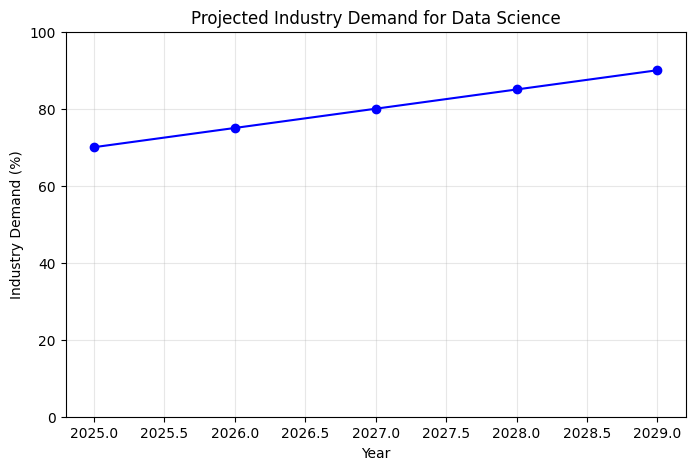

In [91]:
import matplotlib.pyplot as plt

def plot_future_growth(domain):
    # Example mock data: Year vs Demand
    projections = {
        "Data Science": [70, 75, 80, 85, 90],
        "Web Development": [60, 65, 68, 72, 75],
        "Cybersecurity": [65, 70, 78, 82, 88],
        "Software Engineering": [68, 72, 75, 78, 80]
    }
    years = [2025, 2026, 2027, 2028, 2029]
    
    if domain not in projections:
        raise ValueError(f"No projections available for {domain}")

    plt.figure(figsize=(8,5))
    plt.plot(years, projections[domain], marker='o', linestyle='-', color='blue')
    plt.title(f"Projected Industry Demand for {domain}")
    plt.xlabel("Year")
    plt.ylabel("Industry Demand (%)")
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage:
plot_future_growth("Data Science")


In [93]:
in_demand_skills = {
    "Advocate": [
        "Legal Research", "Litigation", "Contract Drafting", "Negotiation",
        "Case Management", "Legal Writing", "Public Speaking"
    ],
    "Arts": [
        "Graphic Design", "Illustration", "Photography", "Adobe Photoshop",
        "Adobe Illustrator", "Creativity", "Art History"
    ],
    "Automation Testing": [
        "Selenium", "TestNG", "Cucumber", "JMeter", "Python", "Java",
        "Automation Frameworks", "Continuous Integration", "API Testing"
    ],
    "Blockchain": [
        "Solidity", "Ethereum", "Smart Contracts", "Cryptography",
        "Blockchain Architecture", "DeFi", "NFT Development"
    ],
    "Business Analyst": [
        "Requirements Gathering", "Data Analysis", "UML", "Process Mapping",
        "SQL", "Stakeholder Communication", "Agile Methodologies"
    ],
    "Civil Engineer": [
        "AutoCAD", "Structural Analysis", "Project Management",
        "Construction Management", "Surveying", "Building Codes"
    ],
    "Data Science": [
        "Python", "Machine Learning", "Deep Learning", "SQL",
        "Data Visualization", "Statistics", "TensorFlow", "PyTorch",
        "Big Data", "Data Cleaning"
    ],
    "Database": [
        "SQL", "MySQL", "PostgreSQL", "Oracle", "Database Design",
        "Stored Procedures", "Performance Tuning"
    ],
    "DevOps Engineer": [
        "CI/CD", "Docker", "Kubernetes", "Jenkins", "AWS", "Linux",
        "Infrastructure as Code", "Git", "Monitoring Tools"
    ],
    "DotNet Developer": [
        "C#", ".NET Core", "ASP.NET", "Entity Framework", "SQL Server",
        "Web API", "MVC Framework", "Azure"
    ],
    "ETL Developer": [
        "ETL Tools", "Informatica", "Talend", "SQL", "Data Warehousing",
        "SSIS", "Data Transformation", "Data Modeling"
    ],
    "Electrical Engineering": [
        "Circuit Design", "Power Systems", "MATLAB", "PLC Programming",
        "Microcontrollers", "Renewable Energy Systems"
    ],
    "HR": [
        "Recruitment", "Employee Relations", "Payroll Management",
        "Training & Development", "Performance Management", "HR Policies"
    ],
    "Hadoop": [
        "HDFS", "MapReduce", "Hive", "Pig", "Spark", "Big Data",
        "YARN", "Data Processing"
    ],
    "Health and fitness": [
        "Nutrition", "Personal Training", "Exercise Physiology",
        "Wellness Coaching", "Injury Prevention", "Public Health"
    ],
    "Java Developer": [
        "Java", "Spring Boot", "Hibernate", "J2EE", "Maven", "JUnit",
        "Microservices", "REST API Development"
    ],
    "Mechanical Engineer": [
        "CAD Software", "SolidWorks", "Thermodynamics", "Manufacturing Processes",
        "Fluid Mechanics", "Product Design"
    ],
    "Network Security Engineer": [
        "Network Security", "Firewalls", "VPN", "IDS/IPS", "SIEM",
        "Penetration Testing", "Incident Response"
    ],
    "Operations Manager": [
        "Process Optimization", "Inventory Management", "Supply Chain Management",
        "Leadership", "Strategic Planning", "Budgeting"
    ],
    "PMO": [
        "Project Management", "Portfolio Management", "Risk Management",
        "Scheduling", "Stakeholder Management", "Agile Frameworks"
    ],
    "Python Developer": [
        "Python", "Django", "Flask", "REST APIs", "Pandas", "NumPy",
        "SQL", "Unit Testing"
    ],
    "SAP Developer": [
        "SAP ABAP", "SAP HANA", "SAP Fiori", "Business Process Integration",
        "Module Customization", "SAP UI5"
    ],
    "Sales": [
        "Lead Generation", "Negotiation", "CRM Tools", "Market Research",
        "Customer Relationship Management", "Presentation Skills"
    ],
    "Testing": [
        "Manual Testing", "Automation Testing", "Selenium", "JUnit",
        "API Testing", "Bug Tracking Tools", "Regression Testing"
    ],
    "Web Designing": [
        "HTML", "CSS", "JavaScript", "UI/UX Design", "Adobe XD", "Figma",
        "Responsive Design", "Bootstrap"
    ]
}


def extract_resume_skills(resume_text):
    all_skills = set()
    resume_lower = resume_text.lower()
    for skill in set(sum(in_demand_skills.values(), [])):  # Flatten skill list
        if skill.lower() in resume_lower:
            all_skills.add(skill)
    return list(all_skills)


def compare_skills(resume_text, predicted_domain):
    current_role_skills = set(in_demand_skills.get(predicted_domain, []))
    resume_skills = set(extract_resume_skills(resume_text))
    
    missing_skills = current_role_skills - resume_skills
    matched_skills = resume_skills & current_role_skills
    
    return {
        "matched": list(matched_skills),
        "missing": list(missing_skills)
    }


resume_text = extract_text_from_file("/Users/brejesh/Downloads/resume/uploads/Brejesh_HSBC.pdf")
predicted_domain = predict_domain(resume_text)

skills_gap = compare_skills(resume_text, predicted_domain)

print("Skills you already have:", skills_gap["matched"])
print("Skills you should develop:", skills_gap["missing"])


Skills you already have: ['Deep Learning', 'TensorFlow', 'SQL', 'Machine Learning', 'Python', 'PyTorch']
Skills you should develop: ['Data Cleaning', 'Statistics', 'Data Visualization', 'Big Data']


In [94]:
import matplotlib.pyplot as plt
import os

def plot_skill_comparison(matched, missing, predicted_domain):
    categories = ["Matched Skills", "Missing Skills"]
    values = [len(matched), len(missing)]

    plt.figure(figsize=(6,4))
    bars = plt.bar(categories, values, color=["green", "red"], alpha=0.7)

    plt.title(f"Skill Match for {predicted_domain}", fontsize=14)
    plt.ylabel("Number of Skills", fontsize=12)

    # Add value labels on bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, 
                 bar.get_height() + 0.2, 
                 str(int(bar.get_height())), 
                 ha="center", fontsize=10)

    plt.tight_layout()

    # Save chart
    chart_path = os.path.join("static", "skill_comparison.png")
    plt.savefig(chart_path)
    plt.close()
    return chart_path
